In [1]:
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()


(50000, 28, 28) (50000,)


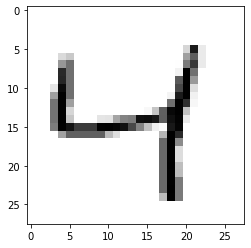

In [9]:
## Printing dimensions
print(X_train.shape, y_train.shape)
## Visualizing the first digit
plt.imshow(X_train[2], cmap="Greys")

In [10]:
X_train_flattened = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test_flattened = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

In [11]:
print('Train dimension:');print(X_train_flattened.shape)
print('Test dimension:');print(X_test_flattened.shape)

Train dimension:
(50000, 784)
Test dimension:
(10000, 784)


In [12]:
print(y_train)

[5 0 4 ... 8 4 8]


In [13]:
lb = LabelBinarizer()

In [14]:
lb

LabelBinarizer()

In [15]:
y_train = lb.fit_transform(y_train)

In [16]:
y_test = lb.transform(y_test)

In [17]:
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.compat.v1.InteractiveSession()

In [39]:
## Defining various initialization parameters for 784-512-256-10 MLP model
num_classes = y_train.shape[1]
num_features = X_train_flattened.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [40]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [41]:
num_features

784

In [42]:
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")


In [43]:
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.placeholder(tf.float32)

In [44]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random_normal([num_output]))

In [45]:
## Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(input_X,weights_0)+bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)

In [46]:
## Defining the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))

In [47]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

In [48]:
## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [50]:
## Training parameters
batch_size = 128
epochs=14
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train_flattened.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train_flattened[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train_flattened, 
                                                         input_y: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {input_X: X_train_flattened, 
                                      input_y: y_train,keep_prob:1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test_flattened,keep_prob:1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 45.17 Train acc: 0.935, Test acc:0.935
Epoch:1, Train loss: 25.48 Train acc: 0.955, Test acc:0.954
Epoch:2, Train loss: 14.56 Train acc: 0.965, Test acc:0.961
Epoch:3, Train loss: 8.50 Train acc: 0.970, Test acc:0.965
Epoch:4, Train loss: 5.15 Train acc: 0.978, Test acc:0.971
Epoch:5, Train loss: 3.34 Train acc: 0.981, Test acc:0.973
Epoch:6, Train loss: 2.39 Train acc: 0.983, Test acc:0.974
Epoch:7, Train loss: 1.90 Train acc: 0.984, Test acc:0.974
Epoch:8, Train loss: 1.66 Train acc: 0.987, Test acc:0.977
Epoch:9, Train loss: 1.55 Train acc: 0.988, Test acc:0.979
Epoch:10, Train loss: 1.50 Train acc: 0.988, Test acc:0.979
Epoch:11, Train loss: 1.48 Train acc: 0.990, Test acc:0.980
Epoch:12, Train loss: 1.47 Train acc: 0.989, Test acc:0.978
Epoch:13, Train loss: 1.47 Train acc: 0.990, Test acc:0.978


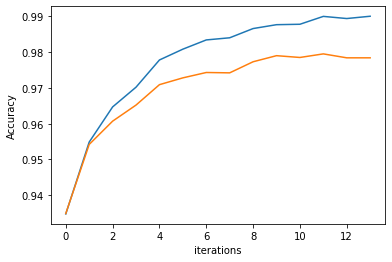

Train Accuracy: 0.99
Test Accuracy:0.98


In [51]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

In [54]:
predicted_labels = s.run(predicted_y, feed_dict = {input_X : X_test_flattened, keep_prob:dropout_prob})

In [55]:
predicted_values = np.argmax(predicted_labels, axis = 1)

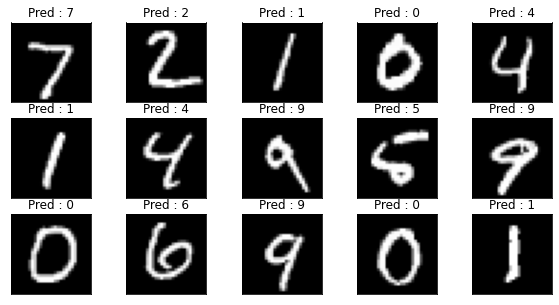

In [78]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (10, 5))
# print(axes)
for i, ax in enumerate(axes.flatten()):
#     ax.add_subplot(3, 5, i)
    ax.imshow(X_test[i], cmap = "gray")
    _ = ax.set_title("Pred : {}".format(str(predicted_values[i])))
    ax.set_xticks([])
    ax.set_yticks([])    